# Prepare matplotlib

In [2]:
from collections import defaultdict
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator, NullFormatter

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

wandb.login()
api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


# Load data

In [3]:
tiny_base = api.run("pico-lm/pico-relora/k718cxi3")
small_base = api.run("pico-lm/pico-relora/cjigjo80")
tiny_lora = api.run("pico-lm/pico-relora/ghbzaf4f")
small_lora = api.run("pico-lm/pico-relora/9nqespc7")

In [4]:
lora_keys = [
    f"cka_val/_forward_module.module.layers.{i}.{mod}.{ltype}.activations"
    for i in range(12)
    for mod in ("swiglu.w_2", "ov_circuit")
    for ltype in ("base", "full", "lora")
]
lora_keys.append("_step")

base_keys = [
    f"cka_val/_forward_module.module.layers.{i}.{mod}.activations"
    for i in range(12)
    for mod in ("swiglu.w_2", "ov_circuit")
]
base_keys.append("_step")


data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history(keys=lora_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history(keys=lora_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history(keys=base_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history(keys=base_keys))
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_9384/3038506182.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_9384/3038506182.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [5]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [6]:
cka_data = {}
for mod in ("swiglu.w_2", "ov_circuit"):
    cka_data[mod] = defaultdict(dict)
    for t in data:
        for s in data[t]:
            metr_str = (
                "cka_val/_forward_module.module.layers.{}"
                + f".{mod}{'.base' if t == 'lora' else ''}.activations"
            )
            val = get_across_ranges(
                data[t][s], metr_str, step_mod=2_000, step_mod_offset=0 if t == "base" else 100
            )
            cka_data[mod][t][s] = val

In [11]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16
SUP_LABEL_SIZE = 18

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_9384/2660797608.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


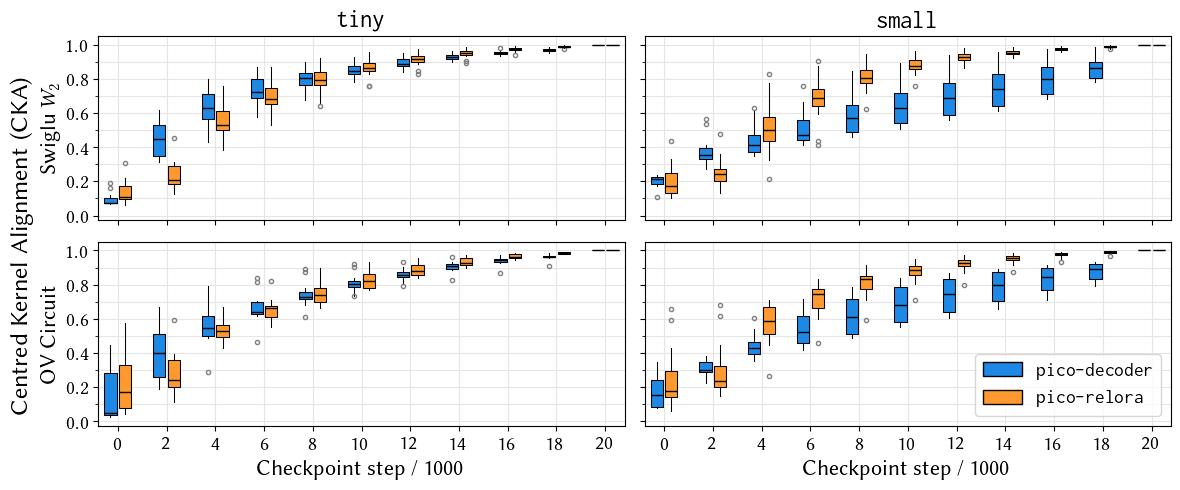

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True)

axs = axs.flatten()

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]

positions = []

steps = np.arange(0, 11, 1) * 2

group_width = 0.9  # Total width for each group of boxes
box_width = 0.5
box_offset = 0.05
real_offset = (box_width / 2) + box_offset
positions = []

for i in steps:
    positions.extend([i - real_offset, i + real_offset])

LINE_WEIGHT = 0.75

data_key = [(mod, scale) for mod in ("swiglu.w_2", "ov_circuit") for scale in ("tiny", "small")]


for ax_id, ax in enumerate(axs):
    mod, scale = data_key[ax_id]

    # box_data = [cka_data[mod][t][scale] for t in ("base", "lora")]

    # box_data = np.column_stack(box_data)

    a = cka_data[mod]["base"][scale].T

    b = cka_data[mod]["lora"][scale].T

    box_data = np.empty((a.shape[0], a.shape[1] + b.shape[1]), dtype=a.dtype)
    box_data[:, ::2] = a
    box_data[:, 1::2] = b

    box_data[:, -1] = np.round(box_data[:, -1], 5)  # stop wrong outlier on last one

    # box_data = box_data[:6,]

    boxplot = ax.boxplot(
        box_data,
        patch_artist=True,
        sym=".",
        notch=False,
        showcaps=False,
        positions=positions,
        widths=box_width,
        medianprops={"color": "black", "linewidth": LINE_WEIGHT + 0.25, "zorder": 4},
        boxprops={"linewidth": LINE_WEIGHT, "zorder": 2},
        whiskerprops={"linewidth": LINE_WEIGHT, "zorder": 2},
        flierprops={
            # "markerfacecolor": "#807F7F",
            "markeredgecolor": "#807F7F",
            "markersize": 6,
        },
    )

    # # Set colors for boxes
    colors = ["#1E88E5", "#FF992F"]
    for idx, patch in enumerate(boxplot["boxes"]):
        patch.set_facecolor(colors[idx % 2])
        # patch.set_alpha(0.7)

    ax.set_xticks(steps, labels=[str(i * 2) for i in range(11)])

    if ax_id == 0:
        ax.set_ylabel(r"Swiglu $W_2$", fontdict=dict(fontsize=AXIS_LABEL_SIZE))
        ax.text(0.5, 1.05, r"\texttt{tiny}", ha="center", fontsize=SUP_LABEL_SIZE, transform=ax.transAxes)
    elif ax_id == 1:
        ax.text(0.5, 1.05, r"\texttt{small}", ha="center", fontsize=SUP_LABEL_SIZE, transform=ax.transAxes)
    elif ax_id == 2:
        ax.set_ylabel("OV Circuit", fontdict=dict(fontsize=AXIS_LABEL_SIZE))
    elif ax_id == 3:
        legend_elements = [
            Patch(facecolor=color, edgecolor="black", label=label) for color, label in zip(colors, labels)
        ]

        # Add the legend
        ax.legend(
            handles=legend_elements,
            loc="lower right",
            bbox_to_anchor=(1, 0),
            # borderaxespad=0,
            fontsize=TICK_LABEL_SIZE,
        )

    if ax_id > 1:
        ax.set_xlabel(r"Checkpoint step / 1000", fontsize=AXIS_LABEL_SIZE)

    ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)

    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.grid(which="both", axis="both", color="#E5E5E5")

fig.supylabel(r"Centred Kernel Alignment (CKA)", fontsize=SUP_LABEL_SIZE)
fig.tight_layout()
fig.savefig("../graphs/cka.pdf")
fig.show()